In [1]:
%env HDF5_USE_FILE_LOCKING=FALSE

import os
import contextlib

import torch
import torch.distributions as dist
import zuko

import tqdm

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle')

import shapely

import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
from cartopy.geodesic import Geodesic

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
lon_min, lon_max = -2.0, 2.0
lat_min, lat_max = 52.0, 56.0

In [3]:
topo_filepath = 'data/south_west_UK_SRTM15Plus.asc'
topo_data_latlon = np.loadtxt(topo_filepath, skiprows=6)

topo_data_latlon = xr.DataArray(
    data=topo_data_latlon,
    dims=['lat', 'lon'],
    coords=dict(
        lon=np.linspace(lon_min, lon_max, topo_data_latlon.shape[1]),
        lat=np.linspace(lat_min, lat_max, topo_data_latlon.shape[0])[::-1],
    ),
    )

In [4]:
def add_distance_coordinates(data_array):
    geod = Geodesic()

    E, N = np.meshgrid(data_array.coords['lon'], data_array.coords['lat'], indexing='ij')
    N_coords = np.stack([E[0, :], N[0, :]], axis=-1)[:, ::-1]
    E_coords = np.stack([E[:, 1], N[:, 1]], axis=-1)[:, ::-1]

    del E, N

    E_km = geod.inverse(E_coords[:1], E_coords)[:, 0]
    N_km = geod.inverse(N_coords[:1], N_coords)[:, 0][::-1]
    
    return E_km, N_km

E, N = add_distance_coordinates(topo_data_latlon)

topo_data_xy = xr.DataArray(
    data=topo_data_latlon.data,
    dims=['N', 'E'],
    coords=dict(
        E=E,
        N=N,
    ),
    )

In [5]:
from geographic_data import landmarks_df, landmarks_latlon, endurance_area_latlon, hornsea_4_latlon
from geographic_data import york_array_centre_latlon, boulby_mine_latlon

def latlong2xy(lat, lon, topo_xarray):
    E, N = add_distance_coordinates(topo_xarray)
    topo_xarray = topo_xarray.assign_coords({'E': ('lon', E,), 'N': ('lat', N,)})
    topo_select = topo_xarray.interp(lon=lon, lat=lat, method='linear')
    return np.vstack((topo_select.coords['E'].data, topo_select.coords['N'].data)).T

endurance_area_xy = latlong2xy(endurance_area_latlon[:, 0], endurance_area_latlon[:, 1], topo_data_latlon)
hornsea_4_xy      = latlong2xy(hornsea_4_latlon[:, 0]     , hornsea_4_latlon[:, 1]     , topo_data_latlon)
landmarks_xy      = latlong2xy(landmarks_latlon[:, 0]     , landmarks_latlon[:, 1]     , topo_data_latlon)

In [6]:
if not os.path.exists('./data/endurance_land_stations.pkl'):
    
    from obspy import UTCDateTime
    from obspy.clients.fdsn import Client
    from obspy.core.inventory import read_inventory
    
    fdsn_client = Client('IRIS')

    #TODO: UKarray (UR) stations are not available on fdsn
    #TODO: station BEDF is missing but should be available

    inv = fdsn_client.get_stations(
        network='GB,UR',
        starttime=UTCDateTime('2023-07-01'),
        minlatitude=lat_min, maxlatitude=lat_max, 
        minlongitude=lon_min, maxlongitude=lon_max,
        level='channel'
        )
    
    seismic_inventory = {}
    for sta in inv[0]:
        seismic_inventory[sta.code] = {'lat': sta.latitude, 'lon': sta.longitude, 'elevation': sta.elevation}
    seismic_inventory = pd.DataFrame(seismic_inventory).T
    
    seismic_inventory.to_pickle('./data/endurance_land_stations.pkl')
else:
    seismic_inventory = pd.read_pickle('./data/endurance_land_stations.pkl') 

seismic_inventory['rms_noise'] = np.array([0.3,0.3,1.3,1.1,0.8,0.8,1.3,1.3,])

seismic_stations_latlon = seismic_inventory[['lat', 'lon']].values
seismic_stations_xy = latlong2xy(seismic_stations_latlon[:, 0], seismic_stations_latlon[:, 1], topo_data_latlon)

In [7]:
topo_spacing  =   4 * 1e3 # 2 km
depth_spacing = 0.2 * 1e3 # 0.5 km

E_seismic_min = np.min(topo_data_xy.coords['E'].data)
E_seismic_max = np.max(topo_data_xy.coords['E'].data)
E_seismic     = np.arange(E_seismic_min, E_seismic_max, topo_spacing)
E_N = len(E_seismic)

N_seismic_min = np.min(topo_data_xy.coords['N'].data)
N_seismic_max = np.max(topo_data_xy.coords['N'].data)
N_seismic     = np.arange(N_seismic_min, N_seismic_max, topo_spacing)
N_N = len(N_seismic)

Z_seismic_min = - 40000.0
Z_seismic_max =    2000.0
Z_seismic    = np.arange(Z_seismic_min, Z_seismic_max, depth_spacing)
Z_N = len(Z_seismic)

print(f'E: {E_seismic_min} - {E_seismic_max} ({len(E_seismic)})')
print(f'N: {N_seismic_min} - {N_seismic_max} ({len(N_seismic)})')
print(f'Z: {Z_seismic_min} - {Z_seismic_max} ({len(Z_seismic)})')

seismic_grid = xr.DataArray(
    np.moveaxis(np.linspace(Z_seismic_min, Z_seismic_max, Z_N).repeat(E_N * N_N).reshape(Z_N, E_N, N_N), 0, -1),
    dims=('easting', 'northing', 'elevation'),
    coords={
        'easting': E_seismic,
        'northing': N_seismic,
        'elevation': Z_seismic
    }
)

elevations = topo_data_xy.interp(E=E_seismic, N=N_seismic, method='linear')
elevations = elevations.values.repeat(Z_N).reshape(N_N, E_N, Z_N).swapaxes(0, 1)

depths = -np.array([0, -Z_seismic_max/1e3, 2.520, 7.550, 18.870, 34.150])*1e3
v_p    =  np.array([4.0,  4.0,   5.9,   6.45,    7.0,   8.0,])*1e3

elevation_grid = seismic_grid.values

seismic_grid.values = np.ones_like(seismic_grid.values)*8000.0


seismic_grid.values[
    (elevation_grid > -34.150e3)
] = 7000.0

seismic_grid.values[
    (elevation_grid > -18.870e3)
] = 7000.0

seismic_grid.values[
    (elevation_grid > -7.550e3)
] = 6450.0

seismic_grid.values[
    (elevation_grid > -2.520e3)
] = 5900.0

seismic_grid.values[
    (elevation_grid > 0)
] = 4000.0

seismic_grid.values[
    (elevation_grid > 1000)
] = 330.0


E: 0.0 - 442298.90674426977 (111)
N: 0.0 - 445008.4159561554 (112)
Z: -40000.0 - 2000.0 (210)


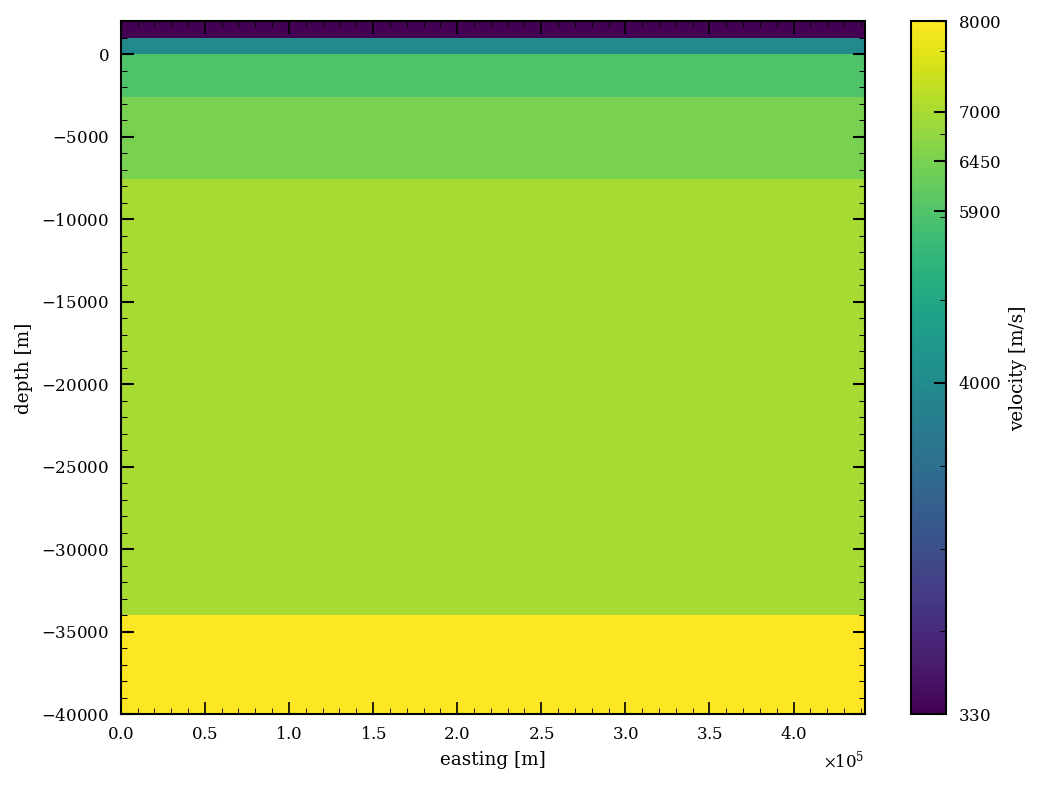

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

im_values = seismic_grid.values[:, 10, :].T

ax.imshow(im_values, origin='lower', extent=[E_seismic_min, E_seismic_max,
                                             Z_seismic_min, Z_seismic_max], cmap='viridis')
ax.set_aspect('auto')

ax.set_xlabel('easting [m]')
ax.set_ylabel('depth [m]')

cbar = plt.colorbar(ax.images[0], ax=ax, label='velocity [m/s]')
cbar.set_ticks(np.unique(im_values))

plt.show()

In [9]:
def get_elevation(points, topo_ds):
    east = xr.DataArray(points[..., 0], dims='points')
    north = xr.DataArray(points[..., 1], dims='points')
    elevations = topo_ds.interp(
        E=east, N=north, method='nearest').values
    return torch.from_numpy(elevations)

In [10]:
receiver_spacing = topo_spacing

receiver_x = np.arange(E_seismic_min, E_seismic_max, receiver_spacing)
receiver_y = np.arange(N_seismic_min, N_seismic_max, receiver_spacing)
X, Y = np.meshgrid(receiver_x, receiver_y, indexing='ij')
receiver_hor_coords = np.vstack([X.ravel(), Y.ravel()]).T

receiver_z = get_elevation(receiver_hor_coords, topo_data_xy)
receiver_coords = np.hstack([receiver_hor_coords, receiver_z[:, None]])

print(f'Number of receivers: {receiver_coords.shape[0]:.2e}')

Number of receivers: 1.24e+04


In [11]:
wells_coords_latlon = np.array(
    [[54.20020528, 0.9916635 , -1020.0],
     [54.24513067, 0.97697506, -1020.0],
     [54.23250939, 1.03511106, -1020.0],
     [54.19777192, 1.05146139, -1020.0],
     [54.21851681, 0.96272839, -1020.0],]
)

wells_coords_xy = np.hstack( [latlong2xy(wells_coords_latlon[:, 0], wells_coords_latlon[:, 1], topo_data_latlon), wells_coords_latlon[:, 2].reshape(-1, 1)])

prior_weights    = torch.ones(wells_coords_xy.shape[0]).float()
prior_means      = torch.from_numpy(wells_coords_xy).float()
prior_covariance = torch.eye(prior_means.shape[1]).expand(prior_means.shape[0], -1, -1) * torch.tensor([5e3, 5e3, 5e2])**2

prior_dist = zuko.distributions.Mixture(dist.MultivariateNormal(
    loc=prior_means, covariance_matrix=prior_covariance), prior_weights)

prior_samples_test = prior_dist.sample((10000,))

In [12]:
prior_mean = wells_coords_xy.mean(axis=0)

print(f'Prior mean: {prior_mean}')

prior_bound_x_min = prior_mean[0] - 5e3 * 5 # five standard deviations
prior_bound_x_max = prior_mean[0] + 5e3 * 5 

prior_bound_y_min = prior_mean[1] - 5e3 * 5 
prior_bound_y_max = prior_mean[1] + 5e3 * 5 

prior_bound_z_min = prior_mean[2] - 5e2 * 5
prior_bound_z_max = prior_mean[2] + 5e2 * 5

Prior mean: [332120.57077692 246849.19373764  -1020.        ]


In [13]:
model_spacing = topo_spacing/2

model_x = np.arange(prior_bound_x_min, prior_bound_x_max, model_spacing)
model_y = np.arange(prior_bound_y_min, prior_bound_y_max, model_spacing)
model_z = np.arange(prior_bound_z_min, prior_bound_z_max, model_spacing/5)

X, Y, Z = np.meshgrid(model_x, model_y, model_z, indexing='ij')

model_coords = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

print(f'Number of model points: {model_coords.shape[0]:.2e}')

Number of model points: 8.12e+03


In [14]:
d_type = np.float32

tt_array = xr.DataArray(
    np.zeros((len(model_x), len(model_y), len(model_z),
              len(receiver_x), len(receiver_y)), dtype=d_type),
    dims=('model_x', 'model_y', 'model_z', 'receiver_x', 'receiver_y'),
    coords={
        'model_x': model_x,
        'model_y': model_y,
        'model_z': model_z,
        'receiver_x': receiver_x,
        'receiver_y': receiver_y,
    }
)

print('Array dimensions: ', tt_array.shape)
print('Memory usage: {:.2f} GB'.format(tt_array.nbytes / 1e9))

Array dimensions:  (25, 25, 13, 111, 112)
Memory usage: 0.40 GB


In [198]:
import pykonal

class Pykonal_Forward:
    def __init__(self, x, y, z, seismic_grid):
        self.x_min, self.x_max, self.x_N = x.min(), x.max(), x.size
        self.y_min, self.y_max, self.y_N = y.min(), y.max(), y.size
        self.z_min, self.z_max, self.z_N = z.min(), z.max(), z.size      

        self.dx = (self.x_max - self.x_min) / self.x_N
        self.dy = (self.y_max - self.y_min) / self.y_N
        self.dz = (self.z_max - self.z_min) / self.z_N

        # add buffer
        self.x_min, self.x_max = self.x_min - self.dx, self.x_max + self.dx
        self.y_min, self.y_max = self.y_min - self.dy, self.y_max + self.dy
        self.z_min, self.z_max = self.z_min - self.dz, self.z_max + self.dz
        
        self.x_N += 2
        self.y_N += 2
        self.z_N += 2
        
        # normalising
        self.normalising = np.array(
            [(self.x_max - self.x_min), (self.y_max - self.y_min), (self.z_max - self.z_min)])
        
        self.offset = np.array([self.x_min, self.y_min, self.z_min])
        
        self.x_min, self.x_max = self.x_min - self.offset[0], self.x_max - self.offset[0]
        self.y_min, self.y_max = self.y_min - self.offset[1], self.y_max - self.offset[1]
        self.z_min, self.z_max = self.z_min - self.offset[2], self.z_max - self.offset[2]
        
        self.x_min, self.x_max = self.x_min / self.normalising[0], self.x_max / self.normalising[0]
        self.y_min, self.y_max = self.y_min / self.normalising[1], self.y_max / self.normalising[1]
        self.z_min, self.z_max = self.z_min / self.normalising[2], self.z_max / self.normalising[2]
        
        self.x_N, self.y_N, self.z_N = self.x_N, self.y_N, self.z_N
        self.dx, self.dy, self.dz = self.dx / self.normalising[0], self.dy / self.normalising[1], self.dz / self.normalising[2]
        
        # shift to positive
        self.x_min, self.x_max = self.x_min + 1, self.x_max + 1
        self.y_min, self.y_max = self.y_min + 1, self.y_max + 1    
        self.z_min, self.z_max = self.z_min + 1, self.z_max + 1    
            
        self.velocity = seismic_grid.values
        # add buffer
        self.velocity = np.pad(self.velocity, (1, 1), mode='edge')
                
        print(self.dx*self.x_N)
                
        print(f'x: {self.x_min} - {self.x_max} ({self.x_N}, {self.dx})')
        print(f'y: {self.y_min} - {self.y_max} ({self.y_N}, {self.dy})')
        print(f'z: {self.z_min} - {self.z_max} ({self.z_N}, {self.dz})')
                
        # self.offset = np.array([self.x_min, self.y_min, self.z_min])
    
        # self.x_min, self.x_max = self.x_min - self.offset[0], self.x_max - self.offset[0]
        # self.y_min, self.y_max = self.y_min - self.offset[1], self.y_max - self.offset[1]
        # self.z_min, self.z_max = self.z_min - self.offset[2], self.z_max - self.offset[2]
        
        # print(f'x: {self.x_min} - {self.x_max} ({self.x_N}, {self.dx})')
        # print(f'y: {self.y_min} - {self.y_max} ({self.y_N}, {self.dy})')
        # print(f'z: {self.z_min} - {self.z_max} ({self.z_N}, {self.dz})')
        
    def forward(self, source_coords, receiver_coords):

        source_coords = (source_coords / (self.normalising - self. ) + 1
        receiver_coords = (receiver_coords / self.normalising) + 1
        

        print(source_coords)
        
        
        print(source_coords)
        print(receiver_coords)
        
        solver = pykonal.solver.PointSourceSolver()
        solver.velocity.min_coords     = self.x_min, self.y_min, self.z_min
        solver.velocity.node_intervals = self.dx, self.dy, self.dz
        solver.velocity.npts           = self.x_N, self.y_N, self.z_N
        solver.velocity.values         = self.velocity
        
        solver.src_loc = source_coords
        solver.solve()
        
        print(solver.traveltime.values)
        
        return solver.traveltime.resample(receiver_coords)

pyk_forward = Pykonal_Forward(
    E_seismic, N_seismic, Z_seismic, seismic_grid)

1.0
x: 1.0 - 2.0 (113, 0.008849557522123894)
y: 1.0 - 2.0 (114, 0.008771929824561403)
z: 1.0 - 2.0 (212, 0.0047169811320754715)


In [207]:
# test_model = np.array([0, 0, 0])

test_model = model_coords[0]
# test_model[2] = 0


test = pyk_forward.forward(test_model, receiver_coords)

print(test)

[1.68564729 1.49089438 0.91658391]
[1.68564729 1.49089438 0.91658391]
[[1.         1.         1.00161145]
 [1.         1.00885096 1.00116119]
 [1.         1.01770191 1.00111379]
 ...
 [1.98230088 1.96475423 0.997957  ]
 [1.98230088 1.97360518 0.99795568]
 [1.98230088 1.98245614 0.9979743 ]]
[[[inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  ...
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]]

 [[inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  ...
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]]

 [[inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  ...
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]]

 ...

 [[inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  ...


In [199]:
import socket
print(socket.gethostname())
hostname = socket.gethostname()

if not hostname == 'TP-P14s':
    filename = f'data/eikonal_lookup/eikonal_lookup_layered_{receiver_spacing:.0f}_receivers_{model_spacing:.0f}_models_{topo_spacing:.0f}_topospacing.nc'
else:
    filename = f'/home/dstrutz/Downloads/ssh_cache/eikonal_lookup/eikonal_lookup_layered_{receiver_spacing:.0f}_receivers_{model_spacing:.0f}_models_{topo_spacing:.0f}_topospacing.nc'
    
print(f'Filename: {filename}')

TP-P14s
Filename: /home/dstrutz/Downloads/ssh_cache/eikonal_lookup/eikonal_lookup_layered_4000_receivers_2000_models_4000_topospacing.nc


In [200]:
indices = torch.cartesian_prod(
    torch.arange(len(model_x)),
    torch.arange(len(model_y)),
    torch.arange(len(model_z)))

In [201]:
indices

tensor([[ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  0,  2],
        ...,
        [24, 24, 10],
        [24, 24, 11],
        [24, 24, 12]])

In [202]:

if os.path.exists(filename):
    tt_array = xr.load_dataarray(
        filename, engine='netcdf4', format='NETCDF4')
else:
    for i, model in tqdm.tqdm(enumerate(model_coords[:2]),
                                total=len(model_coords)):
        
        out = pyk_forward.forward(
                source_coords=model.astype(np.float64),
                receiver_coords=receiver_coords.astype(np.float64)
        )     
        
        out  = out.reshape((len(receiver_x), len(receiver_y)))
        
        tt_array[indices[i, 0], indices[i, 1], indices[i, 2], :, :] = out
        
    # tt_array.to_netcdf(filename, engine='netcdf4', format='NETCDF4')
    

  0%|          | 0/8125 [00:00<?, ?it/s]

[1.68564729 1.49089438 0.91658391]
[1.68564729 1.49089438 0.91658391]
[[1.         1.         1.00161145]
 [1.         1.00885096 1.00116119]
 [1.         1.01770191 1.00111379]
 ...
 [1.98230088 1.96475423 0.997957  ]
 [1.98230088 1.97360518 0.99795568]
 [1.98230088 1.98245614 0.9979743 ]]


  0%|          | 1/8125 [00:00<48:37,  2.78it/s]

[[[inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  ...
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]]

 [[inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  ...
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]]

 [[inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  ...
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]]

 ...

 [[inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  ...
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]]

 [[inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  ...
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf inf]
  [inf inf inf ... inf inf i

  0%|          | 2/8125 [00:08<9:14:57,  4.10s/it] 

[[[1.05289406e-04 1.05282717e-04 1.05289261e-04 ... 2.36733138e-04
   2.50965916e-04 2.65234897e-04]
  [1.04656775e-04 1.04650045e-04 1.04656628e-04 ... 2.36259702e-04
   2.50492528e-04 2.64761555e-04]
  [1.04031976e-04 1.04025206e-04 1.04031828e-04 ... 2.35793604e-04
   2.50026477e-04 2.64295549e-04]
  ...
  [1.04702904e-04 1.04696173e-04 1.04702758e-04 ... 2.36300008e-04
   2.50532830e-04 2.64801853e-04]
  [1.05335924e-04 1.05329233e-04 1.05335780e-04 ... 2.36773891e-04
   2.51006665e-04 2.65275642e-04]
  [1.05976629e-04 1.05969979e-04 1.05976486e-04 ... 2.37255047e-04
   2.51487773e-04 2.65756703e-04]]

 [[1.04390833e-04 1.04384084e-04 1.04390685e-04 ... 2.36063428e-04
   2.50296274e-04 2.64565321e-04]
  [1.03752633e-04 1.03745843e-04 1.03752484e-04 ... 2.35588161e-04
   2.49821056e-04 2.64090149e-04]
  [1.03122267e-04 1.03115436e-04 1.03122117e-04 ... 2.35120251e-04
   2.49353194e-04 2.63622334e-04]
  ...
  [1.03799041e-04 1.03792250e-04 1.03798892e-04 ... 2.35628514e-04
   2.49861

In [203]:
print(model)

[307120.57077692 221849.19373764      0.        ]


In [204]:
print(receiver_coords)

[[ 0.00000000e+00  0.00000000e+00  6.80000000e+01]
 [ 0.00000000e+00  4.00000000e+03  4.90000000e+01]
 [ 0.00000000e+00  8.00000000e+03  4.70000000e+01]
 ...
 [ 4.40000000e+05  4.36000000e+05 -8.62107697e+01]
 [ 4.40000000e+05  4.40000000e+05 -8.62664185e+01]
 [ 4.40000000e+05  4.44000000e+05 -8.54805450e+01]]


In [205]:
print(out)

[[0.00010529 0.00010465 0.00010402 ...        nan        nan        nan]
 [0.00010438 0.00010374 0.0001031  ...        nan        nan        nan]
 [0.00010348 0.00010283 0.00010219 ...        nan        nan        nan]
 ...
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [206]:
tt_array

<xarray.DataArray (model_x: 25, model_y: 25, model_z: 13, receiver_x: 111,
                   receiver_y: 112)>
array([[[[[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          ...,
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]],

         [[0.00010529, 0.00010465, 0.00010402, ...,        nan,
                  nan,        nan],
          [0.00010438, 0.00010374, 0.0001031 , ...,        nan,
                  nan,        nan],
          [0.00010348, 0.00010283, 0.00010219, ...,        nan,
                  nan,        nan],
...
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]],

         [[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]]]]], dtype=float32)
Coordinates:
  * model_x     (model_x) float64 3.071e+05 3.091e+05 ... 3.531e+05 3.551e+05
  * model_y     (model_y) float64 2.218e+05 2.238e+05 ... 2.678e+05 2.698e+05
  * model_z     (model_z) float64 -3.52e+03 -3.12e+03 ... 880.0 1.28e+03
  * receiver_x  (receiver_x) float64 0.0 4e+03 8e+03 ... 4.36e+05 4.4e+05
  * receiver_y  (receiver_y) float64 0.0 4e+03 8e+03 ... 4.4e+05 4.44e+05